<a href="https://colab.research.google.com/github/reyllama/TTIO/blob/master/06_Embedding_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.autograd import Variable
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/corr1.csv"
df = pd.read_csv(path)
df['stock_id'] = df['stock_id'].astype(str)
df = df.set_index(keys='stock_id')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,000120,000140,000145,000150,000155,000157,000180,000210,000215,000220,000225,000227,000230,000240,000250,000270,000300,000320,000325,000370,000390,000400,000430,000440,000480,000490,000500,000520,000540,000545,...,95190,95270,95340,95500,95570,95610,95660,95700,95720,95910,96040,96240,96300,96350,96530,96610,96630,96640,96760,96770,96775,96870,97230,97520,97780,97800,97870,97950,97955,98120,98460,98660,99190,99220,99320,99340,99350,99410,99440,99520
stock_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000020,1.000000,0.221514,-0.037755,-0.021159,0.230919,0.259171,0.176753,0.195048,0.215654,0.175516,0.208703,0.139837,0.071031,0.116629,0.085471,0.165149,0.124488,0.078928,0.049496,0.537236,0.512802,0.303855,0.483129,0.017378,0.482491,-0.072407,0.017935,0.133918,0.041311,0.148041,0.110374,0.294617,0.040400,0.118770,-0.026300,0.162403,0.135262,0.439909,0.150139,0.018031,...,-0.019455,0.068774,0.035582,0.072378,0.177056,0.094984,0.257213,0.118036,0.061175,0.049229,-0.120927,0.027107,0.229460,0.137070,0.333912,0.253663,-0.004647,0.073918,0.436779,0.070719,0.038662,-0.009037,-0.067703,0.160585,0.272692,0.061822,0.225241,0.039099,-0.051827,0.112372,0.146558,0.079731,0.119611,0.284219,0.065122,-0.193870,-0.055491,0.170469,0.298094,0.101488
000040,0.221514,1.000000,-0.084175,0.125700,0.048086,0.144288,-0.026518,0.139692,0.059997,0.230597,0.052476,0.017729,0.078381,0.209605,0.249582,0.245019,0.194707,0.179482,0.216908,0.249301,0.259880,0.179810,0.216462,0.096105,0.369667,0.131545,0.340488,0.217145,-0.060981,0.220581,0.082751,0.271047,0.300337,0.120322,0.053789,0.174838,0.239307,0.215961,0.197419,0.051451,...,0.268494,0.198407,0.206406,0.414345,0.101782,0.059960,0.227716,0.063983,0.198506,0.071940,-0.059623,0.270323,0.338363,0.194589,0.144394,0.157667,0.114744,0.003995,0.296121,0.238160,0.193186,0.199345,0.176108,0.322742,0.215993,0.116542,0.265938,-0.006009,-0.078675,0.207658,0.136085,0.270371,0.137788,0.219789,0.093931,-0.145495,-0.084699,0.106058,0.374286,0.271006
000050,-0.037755,-0.084175,1.000000,-0.026910,0.194396,0.145192,0.064836,0.065237,0.176480,0.184645,0.139954,0.074693,-0.034289,0.035887,0.030783,-0.029888,0.065450,-0.033895,0.003912,-0.018252,-0.050283,-0.105596,0.237094,0.159021,0.055958,-0.161801,0.105222,0.147823,0.026685,0.059532,0.117234,0.064063,0.016387,-0.015661,0.142240,0.177168,-0.066760,0.106400,0.167397,0.047480,...,0.185434,0.091975,0.040803,0.066808,-0.015634,-0.007347,0.165473,0.041894,0.193574,0.004915,0.085066,0.082473,-0.012954,-0.084595,0.112413,0.189654,0.146540,-0.075025,-0.006074,0.014898,0.053050,0.100744,0.187599,0.086372,-0.100047,-0.065204,-0.016283,0.050333,0.018721,0.032135,0.194629,-0.034360,0.241911,-0.094872,0.076623,0.101066,-0.186058,0.078683,0.081244,-0.111201
000060,-0.021159,0.125700,-0.026910,1.000000,0.178085,0.176415,0.025524,0.103304,0.094681,0.087511,0.031110,0.115337,0.369805,0.158645,0.135941,0.104001,0.026601,0.296269,0.305429,0.199097,0.127579,0.156409,-0.046473,0.031214,0.126763,0.006368,0.272023,0.066901,0.042691,0.142887,0.253146,0.276613,0.158297,0.213465,0.280961,0.082161,0.054212,0.177353,0.171967,0.140361,...,-0.016416,0.065066,0.113294,0.249084,0.048593,0.146570,0.088966,0.125445,0.113970,0.061257,-0.018510,0.115044,0.178463,0.144524,0.098360,-0.042493,0.190262,0.153143,0.129936,0.167621,0.240689,0.047773,0.158049,0.017242,0.192288,0.098559,0.234262,0.172853,0.153594,0.259511,0.211723,-0.002448,0.289181,0.101877,0.057986,0.118551,0.005246,0.018182,0.133223,0.102192
000070,0.230919,0.048086,0.194396,0.178085,1.000000,0.658519,0.103320,0.213751,0.344049,0.187832,0.215465,0.226021,0.029073,0.179910,0.198224,0.239788,0.111998,0.209418,0.262103,0.363887,0.244465,0.167201,0.351404,0.071581,0.286885,-0.196303,0.235813,0.029320,0.166511,0.166894,0.243878,0.293949,0.183960,0.070419,0.150535,0.236201,0.186679,0.268939,0.107885,0.221739,...,0.086512,0.061532,0.316266,0.349720,0

In [23]:
def get_embeddings(corr_df=df, n_epochs=100, dim=32, lr=0.01):
  dtype = torch.FloatTensor
  epochs = n_epochs
  emb_dim = dim
  embeddings = Variable(torch.randn(emb_dim, len(df)).type(dtype), requires_grad=True)
  lr = lr
  optimizer = optim.Adam([embeddings], lr=lr)
  mean = np.abs(df).mean().mean()
  coef = 1/mean # Hyper Parameter 변경
  loss_track = []

  for epoch in range(epochs):
    loss = 0
    for i in range(len(df)):
      v1 = embeddings[:, i].view(emb_dim, -1)
      dist = torch.norm(v1 - embeddings, dim=0).view(len(df), 1)
      corrs = torch.from_numpy(np.abs(coef*np.array(df.iloc[:, i]))-1).view(1, len(df)).type(torch.FloatTensor) # abs(rho)
    #   corrs = torch.from_numpy(coef*np.array(df.iloc[:, i])).view(1, len(df)).type(torch.FloatTensor) # rho 교수님 버전
      loss += torch.mm(corrs, dist)/2
    loss_track.append(loss.item())
    if (epoch+1) % 10 == 0:
      print("{0}th epoch in process".format(epoch+1))
      print('running loss: {}'.format(loss.item()))
      print()

    optimizer.zero_grad()
    loss.backward(retain_graph=False)
    optimizer.step()

    with torch.no_grad():
      for element in embeddings:
        element.clamp_(0,1)

  return embeddings

In [24]:
embeddings = get_embeddings(n_epochs=100)

10th epoch in process
running loss: -181625.0625

20th epoch in process
running loss: -387901.125

30th epoch in process
running loss: -595983.6875

40th epoch in process
running loss: -802446.4375

50th epoch in process
running loss: -983116.75

60th epoch in process
running loss: -996550.25

70th epoch in process
running loss: -1030015.1875

80th epoch in process
running loss: -1042055.1875

90th epoch in process
running loss: -1049022.875

100th epoch in process
running loss: -1056596.125



In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print(embeddings.shape)
embeddings_red = TSNE(n_components=2).fit_transform(embeddings.detach().numpy().T)
embeddings_red.shape

torch.Size([32, 1863])


(1863, 2)

In [6]:
## KOSPI 200 가져오기

from bs4 import BeautifulSoup
import os
import re
import requests

BaseUrl = 'http://finance.naver.com/sise/entryJongmok.nhn?&page='

kospi200 = pd.DataFrame(columns=['name', 'stock_id'])

for _ in range(1, 22):
  try:
    url = BaseUrl + str(_)
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'lxml')
    items = soup.find_all('td', {'class':'ctg'})

    for item in items:
      txt = item.a.get('href')
      k = re.search('[\d]+', txt)
      # print(k.group(), item.text)
      if k:
        code = k.group()
        name = item.text
        data = pd.DataFrame(data={'name':[name], 'stock_id':[code]})
        # print(data)
        kospi200 = pd.concat([kospi200, data])
        
  except:
    pass

kospi200.head()

,name,stock_id
0,삼성전자,005930
0,SK하이닉스,000660
0,삼성바이오로직스,207940
0,NAVER,035420
0,셀트리온,068270


In [7]:
# df['stock_id'] = df['stock_id'].astype(str)

pos = []
for id in kospi200['stock_id']:
  if id in df.index:
    pos.append(list(df.index).index(id))
  else:
    pos.append(-1)

pos[:10]

[256, 44, -1, 493, -1, -1, -1, 282, 227, -1]

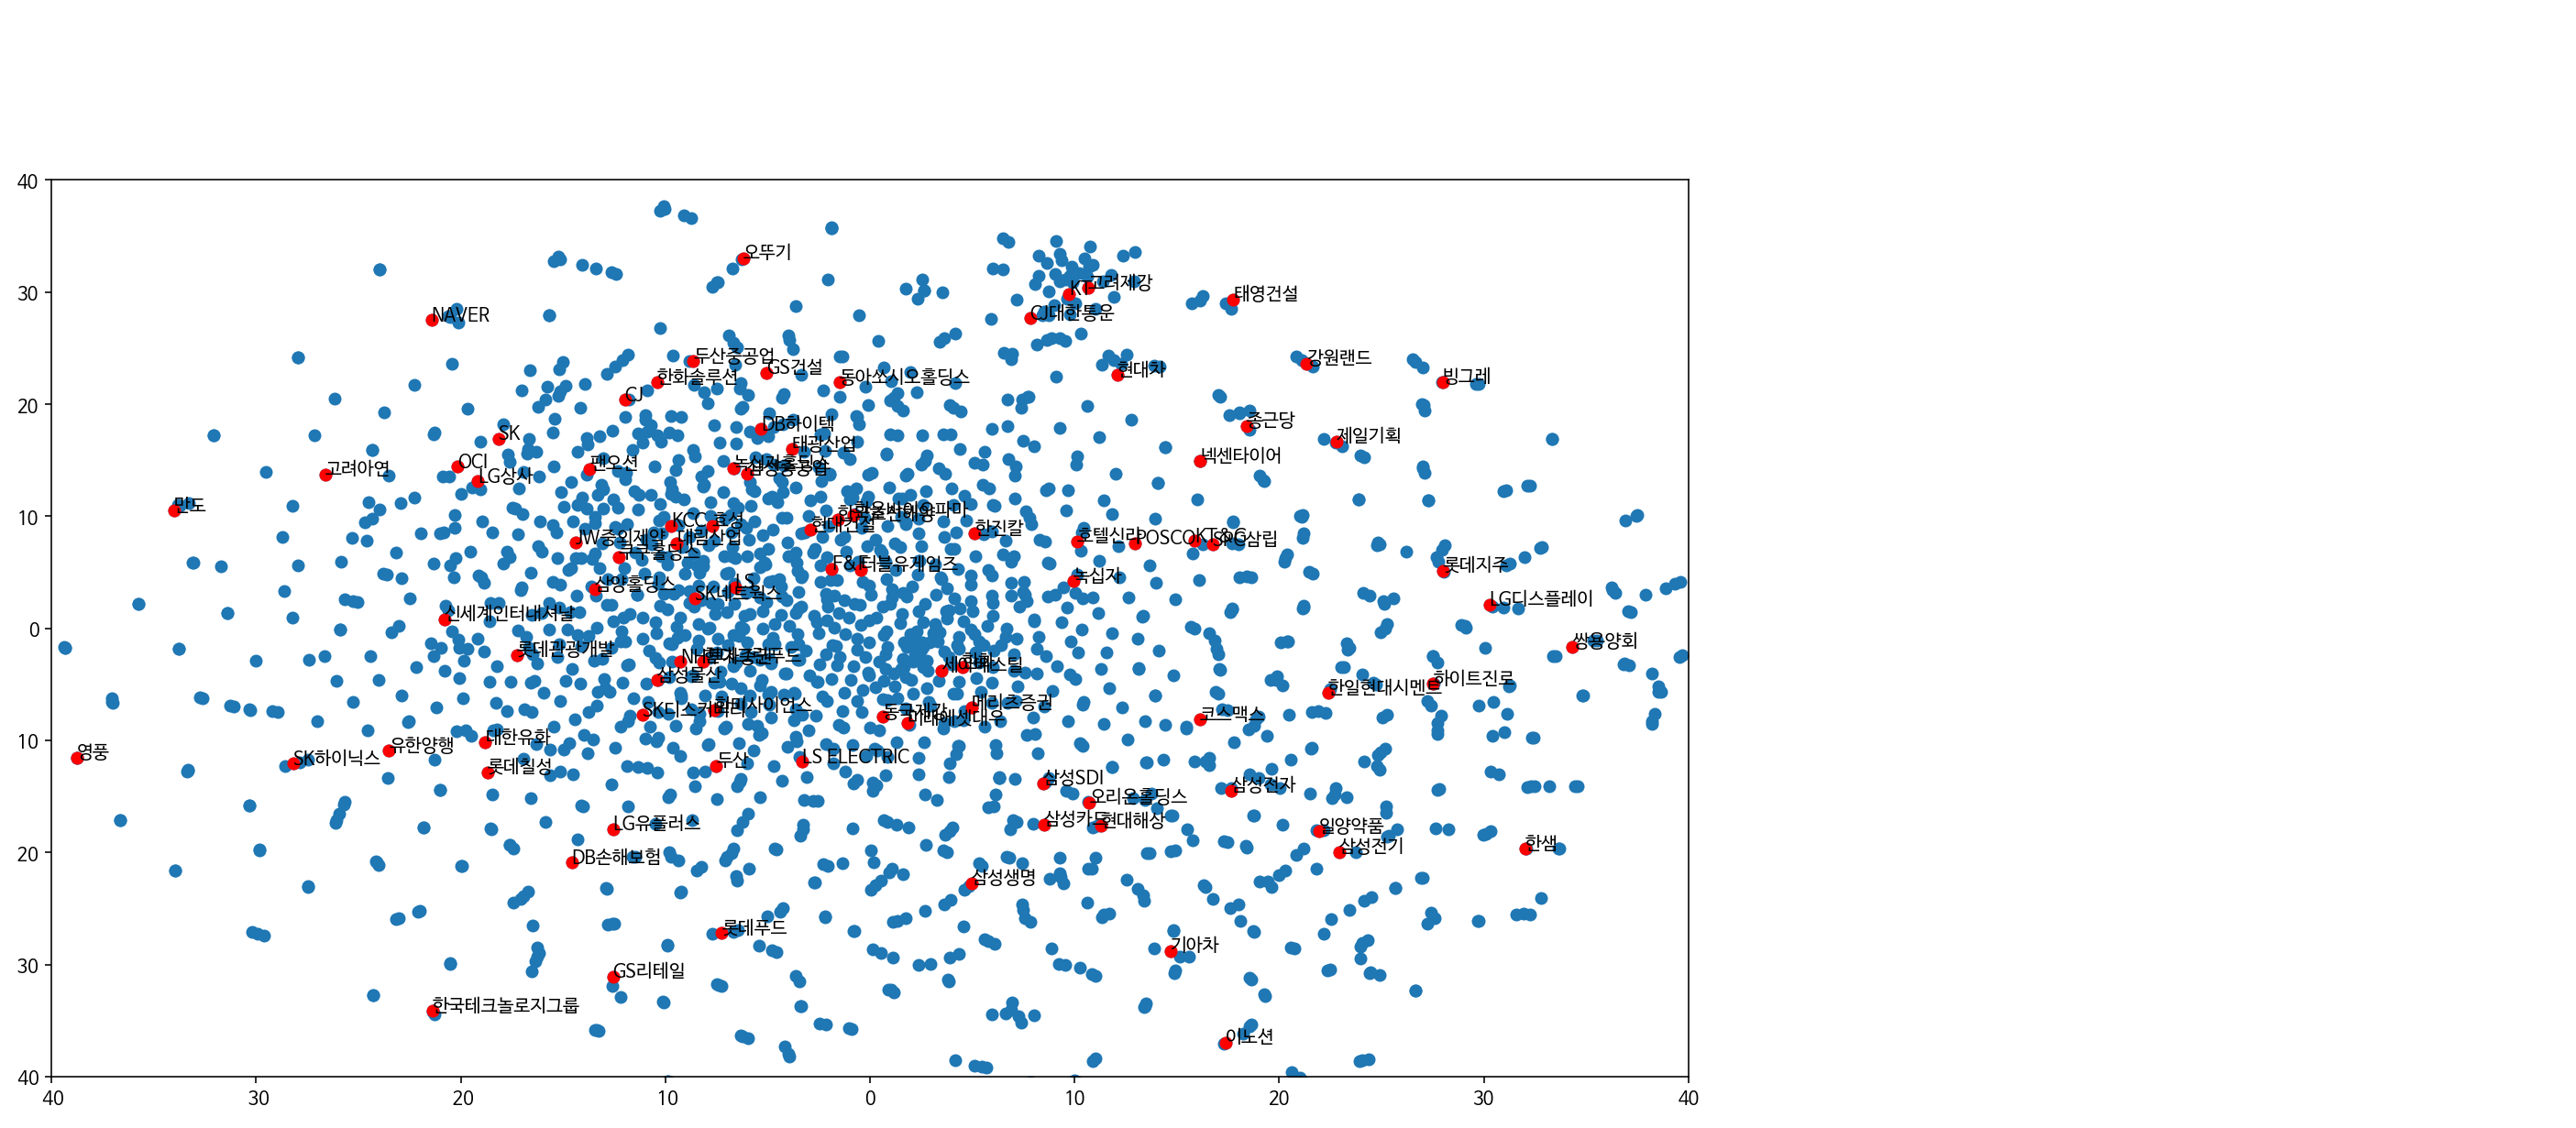

In [28]:
import warnings
warnings.filterwarnings('ignore')

# !apt -qq -y install fonts-nanum > /dev/null
 
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
 
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
# fm._rebuild()
 
# # 그래프에 retina display 적용
# %config InlineBackend.figure_format = 'retina'
 
# # Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumBarunGothic') 

plt.rcParams["figure.figsize"] = (16,9)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(1,1,1)
ax.scatter(embeddings_red[:, 0], embeddings_red[:, 1])
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
for p in pos:
  if p != -1:
    ax.plot(embeddings_red[p, 0], embeddings_red[p, 1], "or")
    ax.annotate(kospi200.iloc[pos.index(p)]['name'], (embeddings_red[p, 0], embeddings_red[p, 1]))
fig.savefig("Embedding_L1.png")